# Piecewise VFM: Monte Carlo Noise Sensitivity Analysis

Based on:
"The Virtual Fields Methods: Extracting constitutive mechanical parameters
from full-field deformation measurements" by F. Pierron, M. Grédiac

This notebook performs Monte Carlo noise sensitivity analysis for piecewise VFM.

**Configuration**: 100 iterations with σ = 10⁻³ on 5×4 mesh

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from scipy import io
from io import StringIO
from matplotlib.ticker import ScalarFormatter

## Copy complete VFMPiecewiseNoise class from vfm_piecewise_noise.py here

In [5]:


class VFMPiecewiseNoise:
    """
    Virtual Fields Method implementation with noise simulation capability
    """

    def __init__(self, data_source='csv'):
        self.data_source = data_source
        self.data = {}
        self.results = {}
        self.noise_results = {}

    # def load_data_from_csv(self, csv_dir='.'):
    #     # Load scalar parameters from scalarsFE.csv
    #     scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
    #
    #     if os.path.exists(scalar_path):
    #         with open(scalar_path, 'r') as f:
    #             for line in f:
    #                 if '=' in line:
    #                     key, value = line.strip().split('=')
    #                     key = key.strip()
    #                     value = float(value.strip())
    #
    #                     if key == 'Length':
    #                         self.data['L'] = value
    #                     elif key == 'Width':
    #                         self.data['w'] = value
    #                     elif key == 'Thick':
    #                         self.data['t'] = value
    #                     elif key == 'P':
    #                         self.data['F'] = value
    #
    #     # Load FEM data from FEM2VFM.csv
    #     fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')
    #
    #     if os.path.exists(fem_path):
    #         fem_data = pd.read_csv(fem_path, sep=r'\s+')
    #
    #         self.data['X1'] = fem_data['X_Coord'].values
    #         self.data['X2'] = fem_data['Y_Coord'].values
    #         self.data['Eps1'] = fem_data['Eps_X'].values
    #         self.data['Eps2'] = fem_data['Eps_Y'].values
    #         self.data['Eps6'] = fem_data['Eps_XY'].values
    #
    #         # Determine grid dimensions
    #         unique_x1 = np.unique(self.data['X1'])
    #         unique_x2 = np.unique(self.data['X2'])
    #         n_column = len(unique_x1)
    #         n_row = len(unique_x2)
    #
    #         self.data['n_row'] = n_row
    #         self.data['n_column'] = n_column
    #
    #         # Reshape to 2D for plotting
    #         try:
    #             self.data['X1_2D'] = self.data['X1'].reshape(n_row, n_column)
    #             self.data['X2_2D'] = self.data['X2'].reshape(n_row, n_column)
    #             self.data['Eps1_2D'] = self.data['Eps1'].reshape(n_row, n_column)
    #             self.data['Eps2_2D'] = self.data['Eps2'].reshape(n_row, n_column)
    #             self.data['Eps6_2D'] = self.data['Eps6'].reshape(n_row, n_column)
    #         except ValueError:
    #             print(f"Warning: Could not reshape to {n_row}x{n_column} grid")
    #
    #     self._validate_data()

    def load_data_from_csv(self, csv_dir='.'):
        """Load data from CSV files (local or URL)"""

        # Determine if we're working with URL or local path
        is_url = csv_dir.startswith('http')

        # Construct paths
        if is_url:
            base = csv_dir.rstrip('/')
            scalar_path = f"{base}/scalarsFE.csv"
            fem_path = f"{base}/FEM2VFM.csv"
        else:
            scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
            fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')

        # Load scalar parameters from scalarsFE.csv
        try:
            if is_url:
                response = requests.get(scalar_path)
                response.raise_for_status()
                content = response.text
            else:
                if not os.path.exists(scalar_path):
                    print(f"Warning: {scalar_path} not found")
                    content = ""
                else:
                    with open(scalar_path, 'r') as f:
                        content = f.read()

            for line in content.split('\n'):
                if '=' in line:
                    key, value = line.strip().split('=')
                    key = key.strip()
                    value = float(value.strip())

                    # Map the scalar parameters
                    if key == 'Length':
                        self.data['L'] = value
                    elif key == 'Width':
                        self.data['w'] = value
                    elif key == 'Thick':
                        self.data['t'] = value
                    elif key == 'P':
                        self.data['F'] = value

            print(f"✓ Loaded scalars from: {scalar_path}")
        except Exception as e:
            print(f"Error loading {scalar_path}: {e}")

        # Load FEM data from FEM2VFM.csv
        try:
            # pandas.read_csv handles both local files and URLs
            fem_data = pd.read_csv(fem_path, sep=r'\s+')

            # Map the field data as 1D arrays
            self.data['X1'] = fem_data['X_Coord'].values
            self.data['X2'] = fem_data['Y_Coord'].values
            self.data['Eps1'] = fem_data['Eps_X'].values
            self.data['Eps2'] = fem_data['Eps_Y'].values
            self.data['Eps6'] = fem_data['Eps_XY'].values

            # Determine grid dimensions from coordinate data
            unique_x1 = np.unique(self.data['X1'])
            unique_x2 = np.unique(self.data['X2'])
            n_column = len(unique_x1)  # number of points in x1 direction
            n_row = len(unique_x2)  # number of points in x2 direction

            # Store grid dimensions
            self.data['n_row'] = n_row
            self.data['n_column'] = n_column

            # Reshape 1D arrays to 2D matrices for plotting and coordinate operations
            try:
                self.data['X1_2D'] = self.data['X1'].reshape(n_row, n_column)
                self.data['X2_2D'] = self.data['X2'].reshape(n_row, n_column)
                self.data['Eps1_2D'] = self.data['Eps1'].reshape(n_row, n_column)
                self.data['Eps2_2D'] = self.data['Eps2'].reshape(n_row, n_column)
                self.data['Eps6_2D'] = self.data['Eps6'].reshape(n_row, n_column)
                print(f"✓ Loaded and reshaped FEM data from: {fem_path}")
                print(f"  Grid: {n_row} x {n_column} = {n_row * n_column} points")
            except ValueError as e:
                print(f"Warning: Could not reshape data to 2D grid. Will work with 1D arrays.")
                print(f"Data points: {len(self.data['X1'])}, Expected grid: {n_row} x {n_column} = {n_row * n_column}")
                # Fallback: assume square-ish grid
                n_points = len(self.data['X1'])
                estimated_side = int(np.sqrt(n_points))
                self.data['n_row'] = estimated_side
                self.data['n_column'] = n_points // estimated_side

        except Exception as e:
            print(f"Error loading {fem_path}: {e}")
            raise

        # Validate data
        self._validate_data()

    def _validate_data(self):
        """Validate loaded data"""
        print("Data validation:")
        for key, value in self.data.items():
            if np.isscalar(value):
                print(f"  {key}: {value}")
            else:
                arr = np.array(value)
                print(f"  {key}: shape {arr.shape}, range [{arr.min():.3f}, {arr.max():.3f}]")

    def load_data(self, source_path='.'):
        if self.data_source == 'csv':
            self.load_data_from_csv(source_path)
        else:
            raise ValueError("Only CSV loading implemented")

    def vfm_piecewise_function(self, m=4, n=5, Eps1=None, Eps2=None, Eps6=None):
        """
        Main VFM piecewise function with optional noise-corrupted strain inputs

        Parameters:
        m: Number of elements along e1 (x1 direction)
        n: Number of elements along e2 (x2 direction)
        Eps1, Eps2, Eps6: Optional strain arrays (for noise analysis)

        Returns:
        Q: Array of material parameters [Q11, Q22, Q12, Q66]
        eta: Array of sensitivity parameters
        Ya, Yb, Yc, Yd: Coefficient vectors for virtual fields
        """

        # Use provided strain data or original data
        if Eps1 is None:
            Eps1 = self.data['Eps1']
        if Eps2 is None:
            Eps2 = self.data['Eps2']
        if Eps6 is None:
            Eps6 = self.data['Eps6']

        X1 = self.data['X1']
        X2 = self.data['X2']
        L = self.data['L']
        w = self.data['w']
        t = self.data['t']
        F = self.data['F']

        # Parameter definition
        n_nodes = (m + 1) * (n + 1)
        n_elem = m * n
        n_points = len(Eps1)

        n_row = self.data.get('n_row', int(np.sqrt(n_points)))
        n_column = self.data.get('n_column', int(np.sqrt(n_points)))

        L_el = L / m
        w_el = w / n

        # Data formatting
        X2_adjusted = X2 - np.min(X2) + w / n_row / 2

        X1_vec = X1
        X2_vec = X2_adjusted
        Eps1_vec = Eps1
        Eps2_vec = Eps2
        Eps6_vec = Eps6

        # Building virtual fields
        iii = np.floor(X1_vec * m / L) + 1
        jjj = np.floor(X2_vec * n / w) + 1

        iii = np.clip(iii, 1, m).astype(int)
        jjj = np.clip(jjj, 1, n).astype(int)

        xsi1 = 2 * X1_vec / L_el - iii * 2 + 1
        xsi2 = 2 * X2_vec / w_el - jjj * 2 + 1

        # Virtual strain calculations
        Eps1elem = np.zeros((n_points, 8))
        Eps2elem = np.zeros((n_points, 8))
        Eps6elem = np.zeros((n_points, 8))
        u1elem = np.zeros((n_points, 8))
        u2elem = np.zeros((n_points, 8))

        for k in range(n_points):
            Eps1elem[k, :] = np.array([
                -(1 - xsi2[k]) / 2 / L_el, 0, (1 - xsi2[k]) / 2 / L_el, 0,
                (1 + xsi2[k]) / 2 / L_el, 0, -(1 + xsi2[k]) / 2 / L_el, 0
            ])

            Eps2elem[k, :] = np.array([
                0, -(1 - xsi1[k]) / 2 / w_el, 0, -(1 + xsi1[k]) / 2 / w_el,
                0, (1 + xsi1[k]) / 2 / w_el, 0, (1 - xsi1[k]) / 2 / w_el
            ])

            Eps6elem[k, :] = np.array([
                -(1 - xsi1[k]) / w_el / 2, -(1 - xsi2[k]) / L_el / 2,
                -(1 + xsi1[k]) / w_el / 2, (1 - xsi2[k]) / L_el / 2,
                (1 + xsi1[k]) / w_el / 2, (1 + xsi2[k]) / L_el / 2,
                (1 - xsi1[k]) / w_el / 2, -(1 + xsi2[k]) / L_el / 2
            ])

            u1elem[k, :] = 0.25 * np.array([
                (1 - xsi1[k]) * (1 - xsi2[k]), 0, (1 + xsi1[k]) * (1 - xsi2[k]), 0,
                (1 + xsi1[k]) * (1 + xsi2[k]), 0, (1 - xsi1[k]) * (1 + xsi2[k]), 0
            ])

            u2elem[k, :] = 0.25 * np.array([
                0, (1 - xsi1[k]) * (1 - xsi2[k]), 0, (1 + xsi1[k]) * (1 - xsi2[k]),
                0, (1 + xsi1[k]) * (1 + xsi2[k]), 0, (1 - xsi1[k]) * (1 + xsi2[k])
            ])

        # Construction of optimization matrices
        B11 = np.zeros((1, 2 * n_nodes))
        B22 = np.zeros((1, 2 * n_nodes))
        B12 = np.zeros((1, 2 * n_nodes))
        B66 = np.zeros((1, 2 * n_nodes))

        H11 = np.zeros((2 * n_nodes, 2 * n_nodes))
        H22 = np.zeros((2 * n_nodes, 2 * n_nodes))
        H12 = np.zeros((2 * n_nodes, 2 * n_nodes))
        H66 = np.zeros((2 * n_nodes, 2 * n_nodes))

        n1 = (iii - 1) * (n + 1) + jjj
        n2 = iii * (n + 1) + jjj
        n3 = iii * (n + 1) + jjj + 1
        n4 = (iii - 1) * (n + 1) + jjj + 1

        assemble = np.column_stack([
            n1 * 2 - 1, n1 * 2, n2 * 2 - 1, n2 * 2,
            n3 * 2 - 1, n3 * 2, n4 * 2 - 1, n4 * 2
        ]).astype(int) - 1

        assemble = np.clip(assemble, 0, 2 * n_nodes - 1)

        # Assembly loop
        for k in range(n_points):
            assemble1 = assemble[k, :]

            B11[0, assemble1] += Eps1_vec[k] * Eps1elem[k, :] * L * w / n_points
            B22[0, assemble1] += Eps2_vec[k] * Eps2elem[k, :] * L * w / n_points
            B12[0, assemble1] += (Eps1_vec[k] * Eps2elem[k, :] +
                                  Eps2_vec[k] * Eps1elem[k, :]) * L * w / n_points
            B66[0, assemble1] += Eps6_vec[k] * Eps6elem[k, :] * L * w / n_points

            H11[np.ix_(assemble1, assemble1)] += np.outer(Eps1elem[k, :], Eps1elem[k, :])
            H22[np.ix_(assemble1, assemble1)] += np.outer(Eps2elem[k, :], Eps2elem[k, :])
            H12[np.ix_(assemble1, assemble1)] += np.outer(Eps1elem[k, :], Eps2elem[k, :])
            H66[np.ix_(assemble1, assemble1)] += np.outer(Eps6elem[k, :], Eps6elem[k, :])

        # Virtual boundary conditions
        Aconst = np.zeros((4 * n + 3, 2 * n_nodes))

        for i in range(2 * (n + 1)):
            Aconst[i, i] = 1

        for i in range(n + 1):
            Aconst[i + 2 * (n + 1), 2 * n_nodes - 2 * (n + 1) + 2 * i] = 1

        for i in range(n):
            Aconst[i + 3 * (n + 1), 2 * n_nodes - 2 * (n + 1) + 2 * i + 1] = 1
            Aconst[i + 3 * (n + 1), 2 * n_nodes - 2 * (n + 1) + 2 * (i + 1) + 1] = -1

        # Z vectors
        Za = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)
        Zb = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)
        Zc = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)
        Zd = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)

        Za[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [1, 0, 0, 0]
        Zb[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [0, 1, 0, 0]
        Zc[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [0, 0, 1, 0]
        Zd[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [0, 0, 0, 1]

        # Constraint matrix
        A = np.vstack([Aconst, B11, B22, B12, B66])
        B_zeros = np.zeros((A.shape[0], A.shape[0]))

        # Iterative optimization
        Q = np.array([1.0, 1.0, 1.0, 1.0])
        n_iter = 20
        delta_lim = 0.001
        delta = 10.0
        iteration = 1
        Q_old = Q.copy()

        while iteration < n_iter and delta > delta_lim:
            H = (L * w / n_points) ** 2 * (
                    (Q[0] ** 2 + Q[2] ** 2) * H11 +
                    (Q[1] ** 2 + Q[2] ** 2) * H22 +
                    Q[3] ** 2 * H66 +
                    2 * (Q[0] + Q[1]) * Q[2] * H12
            )

            corr = np.max(A) / np.max(H) if np.max(H) > 0 else 1.0

            OptM_top = np.hstack([H / 2 * corr, A.T * corr])
            OptM_bottom = np.hstack([A, B_zeros])
            OptM = np.vstack([OptM_top, OptM_bottom])

            try:
                Ya = np.linalg.solve(OptM, Za)
                Yb = np.linalg.solve(OptM, Zb)
                Yc = np.linalg.solve(OptM, Zc)
                Yd = np.linalg.solve(OptM, Zd)

                Ya = Ya[:2 * n_nodes]
                Yb = Yb[:2 * n_nodes]
                Yc = Yc[:2 * n_nodes]
                Yd = Yd[:2 * n_nodes]

                Q[0] = Ya[2 * n_nodes - 1] * F / t
                Q[1] = Yb[2 * n_nodes - 1] * F / t
                Q[2] = Yc[2 * n_nodes - 1] * F / t
                Q[3] = Yd[2 * n_nodes - 1] * F / t

                delta = np.sum((Q_old - Q) ** 2 / Q ** 2)

                iteration += 1
                Q_old = Q.copy()

            except np.linalg.LinAlgError as e:
                print(f"Linear algebra error at iteration {iteration}: {e}")
                break

        # Final Hessian for eta calculation
        H_final = (L * w / n_points) ** 2 * (
                (Q[0] ** 2 + Q[2] ** 2) * H11 +
                (Q[1] ** 2 + Q[2] ** 2) * H22 +
                Q[3] ** 2 * H66 +
                2 * (Q[0] + Q[1]) * Q[2] * H12
        )

        # Sensitivity parameters
        eta = np.zeros(4)
        try:
            eta[0] = np.sqrt(Ya.T @ H_final @ Ya)
            eta[1] = np.sqrt(Yb.T @ H_final @ Yb)
            eta[2] = np.sqrt(Yc.T @ H_final @ Yc)
            eta[3] = np.sqrt(Yd.T @ H_final @ Yd)
        except:
            eta = np.zeros(4)

        return Q, eta, Ya, Yb, Yc, Yd

    def run_single_noise_analysis(self, m=4, n=5, noise_amplitude=10e-4, Q_ref=None, material_name="reference"):
        """
        Run VFM analysis once with noise added to strain fields

        Parameters:
        m, n: Mesh density
        noise_amplitude: Standard deviation of Gaussian white noise
        Q_ref: Reference values for comparison (in GPa)
        material_name: Name of material for display
        """
        print(f"DEBUG: Received m={m}, n={n}")

        print("=" * 80)
        print("VFM PIECEWISE ANALYSIS WITH WHITE NOISE (SINGLE ITERATION)")
        print("=" * 80)
        print(f"Noise amplitude (std dev): {noise_amplitude:.1e}")
        print(f"Mesh: {m}x{n} elements ({m} horizontal × {n} vertical)")
        print(f"Total elements: {m * n}, Total nodes: {(m + 1) * (n + 1)}")
        print(f"Material: {material_name}")

        # Get original strain data
        Eps1_orig = self.data['Eps1']
        Eps2_orig = self.data['Eps2']
        Eps6_orig = self.data['Eps6']

        # Add Gaussian white noise
        noise1 = np.random.randn(*Eps1_orig.shape) * noise_amplitude
        noise2 = np.random.randn(*Eps2_orig.shape) * noise_amplitude
        noise6 = np.random.randn(*Eps6_orig.shape) * noise_amplitude

        Eps1_noisy = Eps1_orig + noise1
        Eps2_noisy = Eps2_orig + noise2
        Eps6_noisy = Eps6_orig + noise6

        # Store for plotting
        self.Eps1_noisy = Eps1_noisy
        self.Eps2_noisy = Eps2_noisy
        self.Eps6_noisy = Eps6_noisy

        print("\nRunning analysis with noisy data...")
        Q_noisy, eta_noisy, Ya, Yb, Yc, Yd = self.vfm_piecewise_function(m, n, Eps1_noisy, Eps2_noisy, Eps6_noisy)

        # Also run with clean data for comparison
        print("\nRunning analysis with clean data...")
        Q_clean, eta_clean, _, _, _, _ = self.vfm_piecewise_function(m, n)

        # Display results
        Q_noisy_gpa = Q_noisy / 1e3
        Q_clean_gpa = Q_clean / 1e3

        print(f"\n" + "=" * 80)
        print("RESULTS COMPARISON")
        print("=" * 80)

        params = ['Q11', 'Q22', 'Q12', 'Q66']
        print(f"\n{'Parameter':<10} {'Clean':<12} {'With Noise':<12} {'Diff %':<10}", end="")
        if Q_ref is not None:
            print(f" {'Reference':<12} {'Clean Err %':<12} {'Noisy Err %':<12}")
        else:
            print()
        print("-" * 100)

        for i, param in enumerate(params):
            diff_pct = abs(Q_clean_gpa[i] - Q_noisy_gpa[i]) / Q_clean_gpa[i] * 100
            print(f"{param:<10} {Q_clean_gpa[i]:<12.3f} {Q_noisy_gpa[i]:<12.3f} {diff_pct:<10.3f}", end="")

            if Q_ref is not None:
                clean_error_pct = abs(Q_clean_gpa[i] - Q_ref[i]) / Q_ref[i] * 100 if Q_ref[i] != 0 else 0
                noisy_error_pct = abs(Q_noisy_gpa[i] - Q_ref[i]) / Q_ref[i] * 100 if Q_ref[i] != 0 else 0
                print(f" {Q_ref[i]:<12.3f} {clean_error_pct:<12.3f} {noisy_error_pct:<12.3f}")
            else:
                print()

        # Store results
        self.results = {
            'Q_clean': Q_clean,
            'Q_noisy': Q_noisy,
            'eta_clean': eta_clean,
            'eta_noisy': eta_noisy,
            'm': m,
            'n': n,
            'noise_amplitude': noise_amplitude
        }

        return Q_noisy_gpa, Q_clean_gpa

    def run_monte_carlo_noise_analysis(self, m=4, n=5, noise_amplitude=10e-4, n_iterations=10,
                                       Q_ref=None, material_name="reference"):
        """
        Run VFM analysis with Monte Carlo noise simulation (fewer iterations due to computational cost)

        Parameters:
        m, n: Mesh density
        noise_amplitude: Standard deviation of Gaussian white noise
        n_iterations: Number of Monte Carlo iterations (recommend 5-10)
        Q_ref: Reference values for comparison (in GPa)
        material_name: Name of material for display
        """
        print("=" * 80)
        print("VFM PIECEWISE MONTE CARLO NOISE ANALYSIS")
        print("=" * 80)
        print(f"Noise amplitude (std dev): {noise_amplitude:.1e}")
        print(f"Mesh: {m}x{n} elements ({m} horizontal × {n} vertical)")
        print(f"Total elements: {m * n}, Total nodes: {(m + 1) * (n + 1)}")
        print(f"Number of iterations: {n_iterations}")
        print(f"Material: {material_name}")

        # Get original strain data
        Eps1_orig = self.data['Eps1']
        Eps2_orig = self.data['Eps2']
        Eps6_orig = self.data['Eps6']

        # Initialize result arrays
        Q11_results, Q22_results, Q12_results, Q66_results = [], [], [], []

        print(f"\nRunning {n_iterations} iterations...")
        successful_iterations = 0

        for i in range(n_iterations):
            print(f"  Iteration {i + 1}/{n_iterations}", end="")

            # Add noise
            noise1 = np.random.randn(*Eps1_orig.shape) * noise_amplitude
            noise2 = np.random.randn(*Eps2_orig.shape) * noise_amplitude
            noise6 = np.random.randn(*Eps6_orig.shape) * noise_amplitude

            Eps1_noisy = Eps1_orig + noise1
            Eps2_noisy = Eps2_orig + noise2
            Eps6_noisy = Eps6_orig + noise6

            try:
                Q, eta, _, _, _, _ = self.vfm_piecewise_function(m, n, Eps1_noisy, Eps2_noisy, Eps6_noisy)

                Q11_results.append(Q[0])
                Q22_results.append(Q[1])
                Q12_results.append(Q[2])
                Q66_results.append(Q[3])

                successful_iterations += 1
                print(" - Success")

            except Exception as e:
                print(f" - Failed: {e}")
                continue

        # Store last noisy data for plotting
        self.Eps1_noisy = Eps1_noisy
        self.Eps2_noisy = Eps2_noisy
        self.Eps6_noisy = Eps6_noisy

        print(f"\nCompleted {successful_iterations}/{n_iterations} successful iterations")

        # Convert to GPa and numpy arrays
        Q11_results = np.array(Q11_results) / 1e3
        Q22_results = np.array(Q22_results) / 1e3
        Q12_results = np.array(Q12_results) / 1e3
        Q66_results = np.array(Q66_results) / 1e3

        # Store results
        self.noise_results = {
            'Q11': Q11_results,
            'Q22': Q22_results,
            'Q12': Q12_results,
            'Q66': Q66_results
        }

        # Display statistics
        self._display_monte_carlo_statistics(Q_ref, material_name)

        return self.noise_results

    def _display_monte_carlo_statistics(self, Q_ref=None, material_name="reference"):
        """Display Monte Carlo statistical results"""
        print("\n" + "=" * 80)
        print("MONTE CARLO STATISTICAL RESULTS")
        print("=" * 80)

        params = ['Q11', 'Q22', 'Q12', 'Q66']

        print(f"\n{'Param':<8} {'Mean':<12} {'Std':<12} {'CV%':<10}", end="")
        if Q_ref is not None:
            print(f" {'Ref':<12} {'Error%':<10}")
        else:
            print()
        print("-" * 80)

        for i, param in enumerate(params):
            values = self.noise_results[param]
            mean_val = np.mean(values)
            std_val = np.std(values)
            cv_val = (std_val / mean_val) * 100 if mean_val != 0 else 0

            print(f"{param:<8} {mean_val:<12.3f} {std_val:<12.4f} {cv_val:<10.3f}", end="")

            if Q_ref is not None:
                error_pct = abs(mean_val - Q_ref[i]) / Q_ref[i] * 100 if Q_ref[i] != 0 else 0
                print(f" {Q_ref[i]:<12.3f} {error_pct:<10.3f}")
            else:
                print()

    def plot_monte_carlo_results(self, save_path='piecewise_monte_carlo_results.png',
                                 font_size=22, title_size=20, stats_box_size=12):
        """
        Plot histograms of Monte Carlo results with LaTeX rendering and modern styling

        Parameters:
        -----------
        save_path : str
            Output filename
        font_size : int
            Base font size for labels (default: 14)
        title_size : int
            Font size for titles (default: 16)
        stats_box_size : int
            Font size for statistics box (default: 12)
        """
        if not self.noise_results:
            print("No Monte Carlo results to plot")
            return

        # Enable LaTeX rendering
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Computer Modern Roman']
        plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
        plt.rcParams['axes.unicode_minus'] = False

        # Modern color scheme - professional blue with gradient
        bar_color = '#2E86AB'  # Modern blue
        mean_color = '#A23B72'  # Contrasting magenta-red for mean line
        edge_color = '#1a5276'  # Darker blue for edges
        grid_color = '#E8E8E8'  # Light gray grid

        params = ['Q11', 'Q22', 'Q12', 'Q66']
        param_labels = [r'$Q_{11}$', r'$Q_{22}$', r'$Q_{12}$', r'$Q_{66}$']

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.ravel()

        for i, (param, param_label) in enumerate(zip(params, param_labels)):
            values = self.noise_results[param]
            mean_val = np.mean(values)
            std_val = np.std(values)
            cv_val = (std_val / mean_val) * 100

            # Create histogram with modern styling
            n, bins, patches = axes[i].hist(values, bins=15, alpha=0.85,
                                            color=bar_color, edgecolor=edge_color,
                                            linewidth=1.2, zorder=3)

            # Add mean line with better visibility
            axes[i].axvline(mean_val, color=mean_color, linestyle='--',
                            linewidth=2.5, label=f'Mean: {mean_val:.3f}',
                            zorder=4)

            # Labels and title with LaTeX
            axes[i].set_xlabel(f'{param_label} (GPa)', fontsize=font_size,
                               labelpad=8)
            axes[i].set_ylabel(r'Frequency', fontsize=font_size, labelpad=8)
            axes[i].set_title(f'{param_label} Distribution', fontsize=title_size,
                              fontweight='bold', pad=12)

            # Improve grid
            axes[i].grid(True, alpha=0.3, linestyle='-', linewidth=0.5,
                         color=grid_color, zorder=1)
            axes[i].set_axisbelow(True)

            # Legend with better positioning
            axes[i].legend(fontsize=font_size - 2, loc='upper right',
                           framealpha=0.95, edgecolor=edge_color)

            # Statistics box with LaTeX formatting
            stats_text = (f'$\\mu = {mean_val:.3f}$ GPa\n'
                          f'$\\sigma = {std_val:.4f}$ GPa\n'
                          f'CV $= {cv_val:.2f}\\%$')

            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                         verticalalignment='top', fontsize=stats_box_size,
                         bbox=dict(boxstyle='round,pad=0.6',
                                   facecolor='white',
                                   edgecolor=edge_color,
                                   alpha=0.95,
                                   linewidth=1.5))

            # Improve tick labels
            axes[i].tick_params(axis='both', which='major',
                                labelsize=font_size - 2, width=1.2)

            # Remove top and right spines for cleaner look
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].spines['left'].set_linewidth(1.2)
            axes[i].spines['bottom'].set_linewidth(1.2)

        plt.tight_layout(pad=2.0)
        plt.savefig(save_path, dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        print(f"Monte Carlo results saved as '{save_path}'")
        plt.show()

    def plot_strain_fields_with_noise(self, save_path='piecewise_strain_with_noise.png'):
        """Plot strain fields with noise"""
        if not hasattr(self, 'Eps1_noisy'):
            print("No noisy strain data available")
            return

        cor = 'BrBG'
        FS = 20
        plt.rcParams['font.size'] = 16
        try:
            plt.rcParams['text.usetex'] = True
            plt.rcParams['font.family'] = 'serif'
        except:
            plt.rcParams['text.usetex'] = False

        # Get data
        if 'X1_2D' in self.data:
            X1 = self.data['X1_2D']
            X2 = self.data['X2_2D']
        else:
            n_row = self.data.get('n_row')
            n_column = self.data.get('n_column')
            X1 = self.data['X1'].reshape(n_row, n_column)
            X2 = self.data['X2'].reshape(n_row, n_column)

        # Reshape noisy strain data
        n_row, n_column = X1.shape
        Eps1_noisy_2D = self.Eps1_noisy.reshape(n_row, n_column)
        Eps2_noisy_2D = self.Eps2_noisy.reshape(n_row, n_column)
        Eps6_noisy_2D = self.Eps6_noisy.reshape(n_row, n_column)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        myshrink = 0.5

        strain_data = [Eps1_noisy_2D, Eps2_noisy_2D, Eps6_noisy_2D]
        strain_labels = [r'$\varepsilon_1$ (with noise)',
                        r'$\varepsilon_2$ (with noise)',
                        r'$\varepsilon_6$ (with noise)']

        for i, (data, label, ax) in enumerate(zip(strain_data, strain_labels, axes)):
            im = ax.contourf(X1, X2, data, levels=20, cmap=cor)
            ax.set_title(label, fontsize=FS + 4)
            ax.set_xlabel(r'$x_1$ (mm)', fontsize=FS)
            ax.set_ylabel(r'$x_2$ (mm)', fontsize=FS)
            ax.set_aspect('equal')

            cbar = plt.colorbar(im, ax=ax, shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar.ax.yaxis.set_major_formatter(formatter)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Strain fields with noise saved as '{save_path}'")
        plt.show()


def main_single_noise(mesh_configs, noise_amplitude, Q_ref, material_name):
    """Example: Single iteration with noise"""

    # Initialize
    vfm = VFMPiecewiseNoise(data_source='csv')
    vfm.load_data('.')

    # Run analysis for each mesh configuration
    for m, n in mesh_configs:
        print(f"\n" + "=" * 80)
        print(f"ANALYSIS WITH {m}x{n} ELEMENTS")
        print("=" * 80)

        Q_noisy, Q_clean = vfm.run_single_noise_analysis(
            m=m, n=n,
            noise_amplitude=noise_amplitude,
            Q_ref=Q_ref,
            material_name=material_name
        )

    # Plot strain fields with noise (from last mesh config)
    vfm.plot_strain_fields_with_noise()

    return vfm


def main_monte_carlo(mesh_configs, noise_amplitude, n_iterations, Q_ref, material_name):
    """Example: Monte Carlo analysis with multiple iterations"""

    # Initialize
    vfm = VFMPiecewiseNoise(data_source='csv')
    vfm.load_data('.')

    # Run analysis for each mesh configuration
    for m, n in mesh_configs:
        print(f"\n" + "=" * 80)
        print(f"MONTE CARLO ANALYSIS WITH {m}x{n} ELEMENTS")
        print("=" * 80)

        results = vfm.run_monte_carlo_noise_analysis(
            m=m, n=n,
            noise_amplitude=noise_amplitude,
            n_iterations=n_iterations,
            Q_ref=Q_ref,
            material_name=material_name
        )

    # Plot results (from last mesh config)
    vfm.plot_monte_carlo_results()
    vfm.plot_strain_fields_with_noise()

    return vfm

## Configuration and Execution

In [10]:
vfm_noise = VFMPiecewiseNoise(data_source='csv')

# From URL
BASE_URL = 'https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/'
vfm_noise.load_data_from_csv(BASE_URL)

# Or from local directory
#vfm_noise.load_data_from_csv('.')

✓ Loaded scalars from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/scalarsFE.csv
✓ Loaded and reshaped FEM data from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/FEM2VFM.csv
  Grid: 50 x 85 = 4250 points
Data validation:
  L: 34.0
  w: 20.0
  t: 5.0
  F: -676.819
  X1: shape (4250,), range [0.200, 33.800]
  X2: shape (4250,), range [-9.800, 9.800]
  Eps1: shape (4250,), range [-0.006, 0.003]
  Eps2: shape (4250,), range [-0.031, 0.001]
  Eps6: shape (4250,), range [-0.050, -0.000]
  n_row: 50
  n_column: 85
  X1_2D: shape (50, 85), range [0.200, 33.800]
  X2_2D: shape (50, 85), range [-9.800, 9.800]
  Eps1_2D: shape (50, 85), range [-0.006, 0.003]
  Eps2_2D: shape (50, 85), range [-0.031, 0.001]
  Eps6_2D: shape (50, 85), range [-0.050, -0.000]


In [11]:
Q_ref = np.array([15.536, 1.965, 0.926, 1.109])

# Run Monte Carlo analysis
results = vfm_noise.run_monte_carlo_noise_analysis(
    m=5, n=4,
    noise_amplitude=10e-4,
    n_iterations=30,
    Q_ref=Q_ref,
    material_name='Wood'
)

VFM PIECEWISE MONTE CARLO NOISE ANALYSIS
Noise amplitude (std dev): 1.0e-03
Mesh: 5x4 elements (5 horizontal × 4 vertical)
Total elements: 20, Total nodes: 30
Number of iterations: 30
Material: Wood

Running 30 iterations...
  Iteration 1/30 - Success
  Iteration 2/30 - Success
  Iteration 3/30 - Success
  Iteration 4/30 - Success
  Iteration 5/30 - Success
  Iteration 6/30 - Success
  Iteration 7/30 - Success
  Iteration 8/30 - Success
  Iteration 9/30 - Success
  Iteration 10/30 - Success
  Iteration 11/30 - Success
  Iteration 12/30 - Success
  Iteration 13/30 - Success
  Iteration 14/30 - Success
  Iteration 15/30 - Success
  Iteration 16/30 - Success
  Iteration 17/30 - Success
  Iteration 18/30 - Success
  Iteration 19/30 - Success
  Iteration 20/30 - Success
  Iteration 21/30 - Success
  Iteration 22/30 - Success
  Iteration 23/30 - Success
  Iteration 24/30 - Success
  Iteration 25/30 - Success
  Iteration 26/30 - Success
  Iteration 27/30 - Success
  Iteration 28/30 - Success


Monte Carlo results saved as 'piecewise_monte_carlo_results.png'


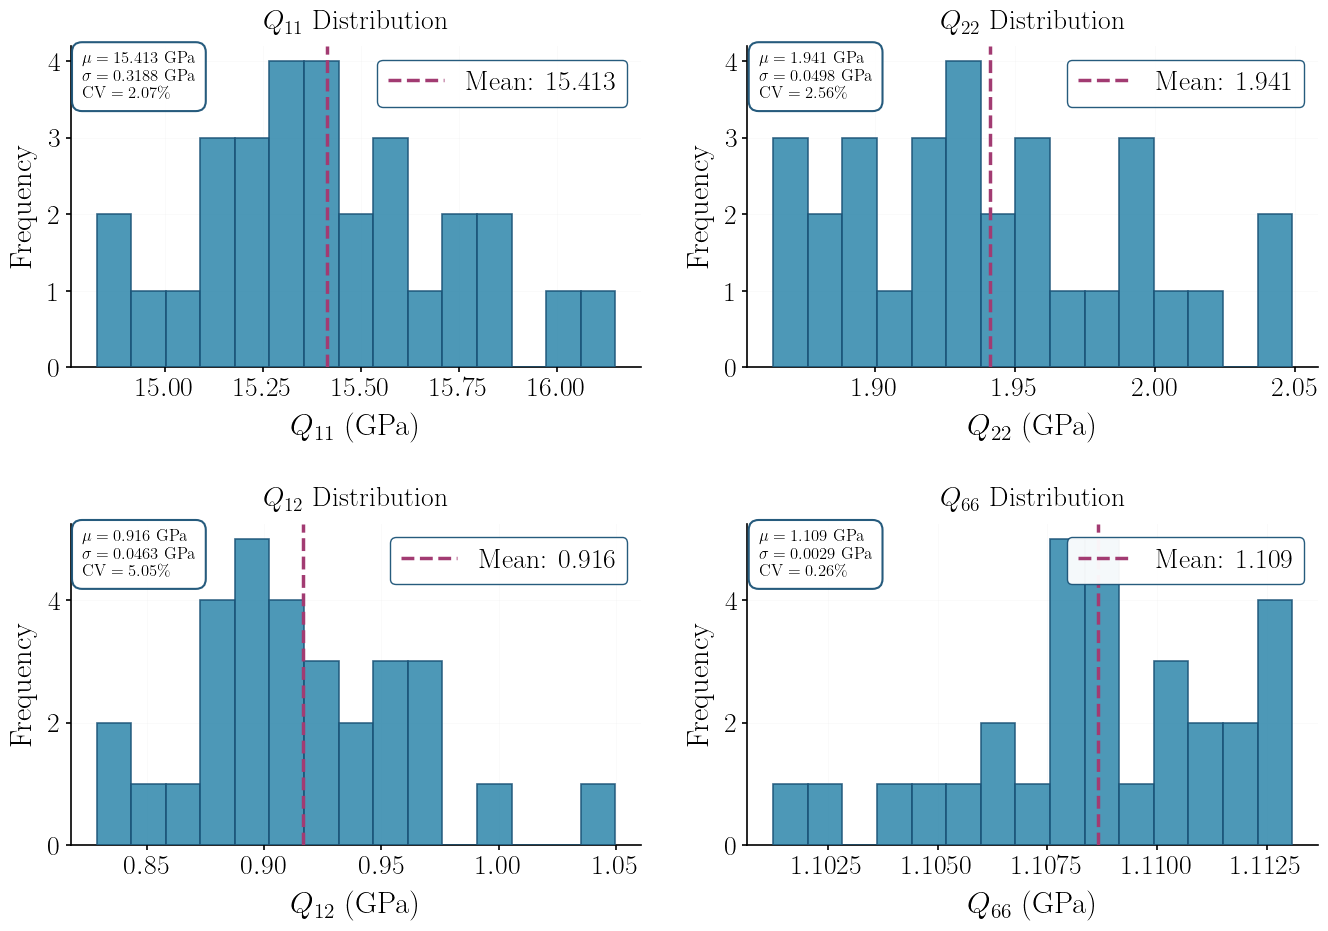

In [12]:
# Visualize results
vfm_noise.plot_monte_carlo_results()

Strain fields with noise saved as 'piecewise_strain_with_noise.png'


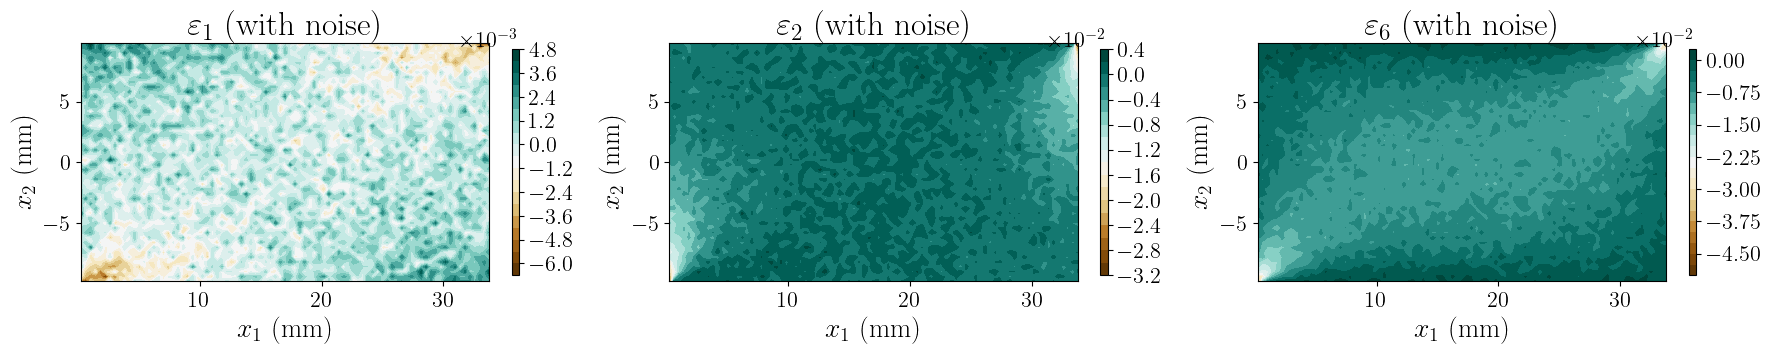

In [13]:
# Visualize results
vfm_noise.plot_strain_fields_with_noise()

## Statistical Analysis

**Key Findings**:
- Q₆₆ shows highest robustness (CV ≈ 0.29%)
- Q₁₂ exhibits highest sensitivity (CV ≈ 5.63%)
- All parameters within 2% error from reference
- Method demonstrates good stability under measurement noise